In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from cmapPy.pandasGEXpress.parse import parse
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA

from sklearn.decomposition import PCA as sklearnPCA
from mpl_toolkits.mplot3d import Axes3D

from GSVA import gsva
from plotnine import *
from sklearn.manifold import TSNE

In [2]:
data = parse("PAAD.gct")
print(type(data))

<class 'cmapPy.pandasGEXpress.GCToo.GCToo'>


In [3]:
# Read all portion of data
col_data = data.col_metadata_df
row_data = data.row_metadata_df
new_data = data.data_df

In [4]:
# Shape of columns metadata
col_data.shape

(183, 124)

Total 86 columns have missing value, and Total 9659 missing values in dataset


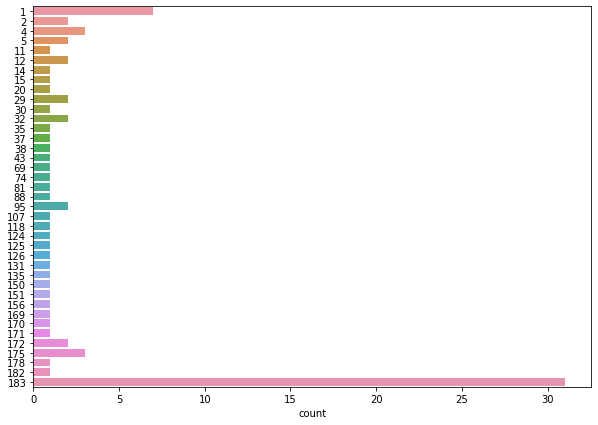

In [6]:
# Number of missing values in each column of col_meta_data
missing_val_count_by_column = (col_data.isnull().sum())
missing_val_count_by_col = missing_val_count_by_column[missing_val_count_by_column > 0].sort_values(ascending=False)
print(f"Total {len(missing_val_count_by_col)} columns have missing value, and",
      f"Total {col_data.isnull().sum().sum()} missing values in dataset")
plt.figure(figsize=(10, 7))
sns.countplot(data=missing_val_count_by_col, y= missing_val_count_by_col )

In [7]:
# Explore each columns of col_meatadata
for col in col_data.columns:
    print(f"{col}:   {len(col_data[col].unique())} unique values:")

participant_id:   178 unique values:
sample_type:   3 unique values:
mRNAseq_cluster:   6 unique values:
bcr_patient_barcode:   178 unique values:
bcr_patient_uuid:   178 unique values:
vital_status:   2 unique values:
days_to_death:   90 unique values:
days_to_last_followup:   85 unique values:
additional_studies:   1 unique values:
adenocarcinoma_invasion:   2 unique values:
age_at_initial_pathologic_diagnosis:   45 unique values:
alcohol_history_documented:   3 unique values:
alcoholic_exposure_category:   6 unique values:
amount_of_alcohol_consumption_per_day:   7 unique values:
anatomic_neoplasm_subdivision:   4 unique values:
anatomic_neoplasm_subdivision_other:   11 unique values:
b_symptoms:   1 unique values:
bcr:   1 unique values:
bcr_aliquot_uuid:   178 unique values:
bcr_canonical_reason-2:   2 unique values:
bcr_canonical_reason-3:   2 unique values:
bcr_canonical_reason:   4 unique values:
bcr_followup_barcode:   151 unique values:
bcr_followup_uuid:   151 unique values:

In [8]:
# drop columns which have constant value
for col in col_data.columns:
    if len(col_data[col].unique())<2:
        col_data.drop(columns=col, inplace=True)


In [9]:
col_data.shape

(183, 83)

In [10]:
col_data.adenocarcinoma_invasion.value_counts()

yes    182
no       1
Name: adenocarcinoma_invasion, dtype: int64

No handles with labels found to put in legend.


RNA sequence cluster:3.0 types patient is 24.16% of total 
RNA sequence cluster:4.0 types patient is 22.47% of total 
RNA sequence cluster:1.0 types patient is 21.91% of total 
RNA sequence cluster:5.0 types patient is 16.85% of total 
RNA sequence cluster:2.0 types patient is 14.61% of total 


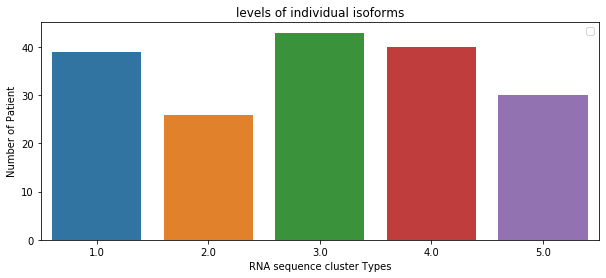

In [11]:
conts_mRNA = col_data.mRNAseq_cluster.value_counts()
plt.figure(figsize=(10,4))
sns.barplot(x=conts_mRNA.index,y=conts_mRNA.values,)
plt.ylabel('Number of Patient')
plt.xlabel('RNA sequence cluster Types')
plt.title('levels of individual isoforms')
plt.legend()
for i, index in enumerate(conts_mRNA.index):
    val = conts_mRNA.values[i]
    val_pcn = round(((val)/sum(conts_mRNA.values))*100, 2)
    print(f"RNA sequence cluster:{index} types patient is {val_pcn}% of total ")

Text(0.5, 1.0, 'Vital status of patient by mRNA sequence cluster types ')

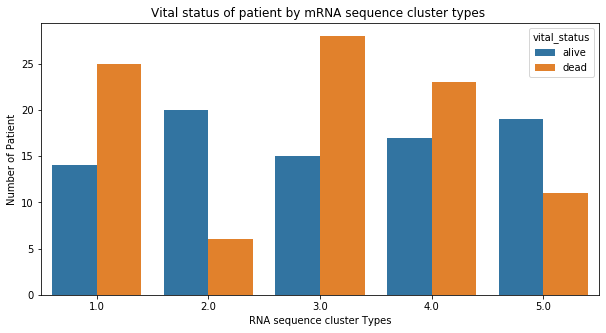

In [13]:
mRNA_seq_group = col_data.groupby(['mRNAseq_cluster', 'vital_status'])['vital_status'].count().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.barplot(x='mRNAseq_cluster', y='counts', hue='vital_status', data=mRNA_seq_group)
plt.ylabel('Number of Patient')
plt.xlabel('RNA sequence cluster Types')
plt.title('Vital status of patient by mRNA sequence cluster types ')

In [14]:
for cluster_type in mRNA_seq_group.mRNAseq_cluster.unique():
    data = mRNA_seq_group[mRNA_seq_group.mRNAseq_cluster==cluster_type]
    live_pcn = round((data[data['vital_status']=='alive']['counts']
                      /sum(data.counts.values))*100, 2)
    dead_pcn = round((data[data['vital_status']=='dead']['counts']/
                     sum(data.counts.values))*100, 2)
    print(f"mRNAseq_cluster type {cluster_type} patient dead {dead_pcn.values[0]}% times")
    print(f"mRNAseq_cluster type {cluster_type} patient alive {live_pcn.values[0]}% times")
    print("\n")

mRNAseq_cluster type 1.0 patient dead 64.1% times
mRNAseq_cluster type 1.0 patient alive 35.9% times


mRNAseq_cluster type 2.0 patient dead 23.08% times
mRNAseq_cluster type 2.0 patient alive 76.92% times


mRNAseq_cluster type 3.0 patient dead 65.12% times
mRNAseq_cluster type 3.0 patient alive 34.88% times


mRNAseq_cluster type 4.0 patient dead 57.5% times
mRNAseq_cluster type 4.0 patient alive 42.5% times


mRNAseq_cluster type 5.0 patient dead 36.67% times
mRNAseq_cluster type 5.0 patient alive 63.33% times




In [15]:
col_data.sample_type.value_counts()

Primary solid Tumor    178
Solid Tissue Normal      4
Metastatic               1
Name: sample_type, dtype: int64

Text(0.5, 1.0, 'Vital status vs cancer type ')

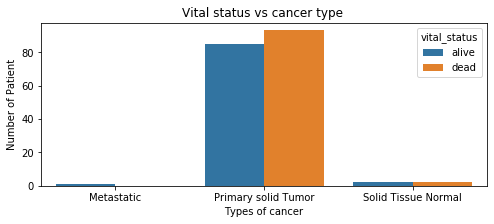

In [16]:
sample_type_group = col_data.groupby(['sample_type', 'vital_status'])['vital_status'].count().reset_index(name='counts')
plt.figure(figsize=(8, 3))
sns.barplot(x='sample_type', y='counts', hue='vital_status', data=sample_type_group)
plt.ylabel('Number of Patient')
plt.xlabel('Types of cancer')
plt.title('Vital status vs cancer type ')

In [17]:
col_data.adenocarcinoma_invasion.value_counts()

yes    182
no       1
Name: adenocarcinoma_invasion, dtype: int64

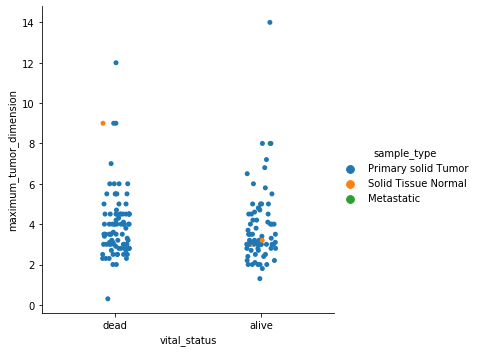

In [19]:
sns.catplot(x='vital_status', y='maximum_tumor_dimension', hue='sample_type', data=col_data)

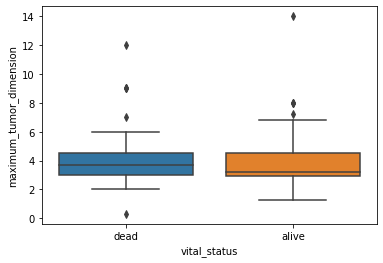

In [20]:
sns.boxplot(x='vital_status', y='maximum_tumor_dimension', data=col_data)

In [21]:
col_data.pathologic_stage.value_counts()

stage iib    122
stage iia     29
stage ib      15
stage iv       5
stage ia       5
stage iii      4
stage i        1
Name: pathologic_stage, dtype: int64

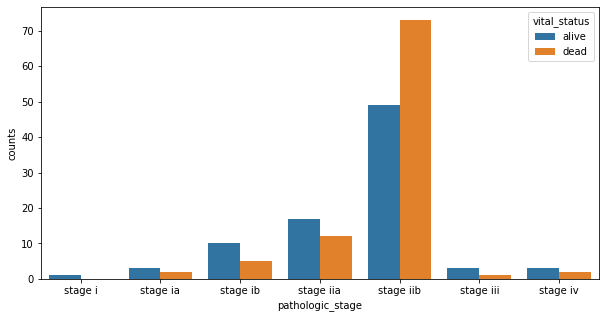

In [22]:
pathologic_stage_group = col_data.groupby(['pathologic_stage', 'vital_status'])['vital_status'].count().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.barplot(x='pathologic_stage', y='counts', hue='vital_status', data=pathologic_stage_group)

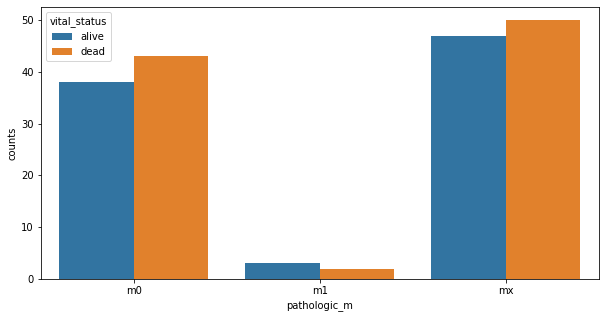

In [23]:
pathologic_m_group = col_data.groupby(['pathologic_m', 'vital_status'])['vital_status'].count().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.barplot(x='pathologic_m', y='counts', hue='vital_status', data=pathologic_m_group)

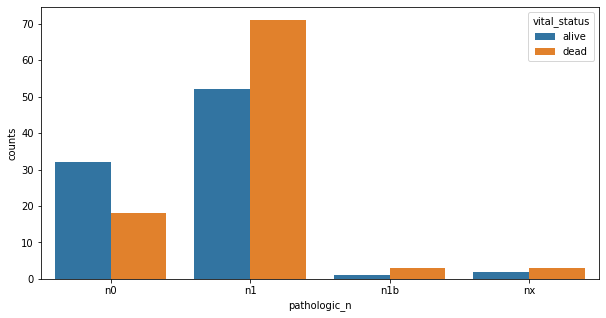

In [24]:
pathologic_n_group = col_data.groupby(['pathologic_n', 'vital_status'])['vital_status'].count().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.barplot(x='pathologic_n', y='counts', hue='vital_status', data=pathologic_n_group)

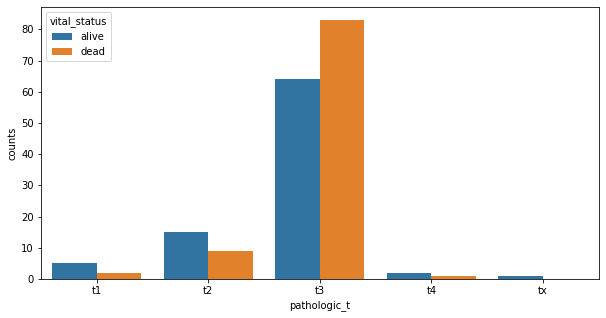

In [25]:
pathologic_t_group = col_data.groupby(['pathologic_t', 'vital_status'])['vital_status'].count().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.barplot(x='pathologic_t', y='counts', hue='vital_status', data=pathologic_t_group)

In [27]:
print(row_data.index[:5])
print(row_data.shape)
row_data.head()

Index(['SLC35E2', 'A1BG', 'A1CF', 'A2BP1', 'A2LD1'], dtype='object', name='rid')
(18465, 0)


rhd
rid
SLC35E2
A1BG
A1CF
A2BP1
A2LD1


In [28]:
new_data.head()

cid,aab1-Primary solid Tumor,aab4-Primary solid Tumor,aab6-Primary solid Tumor,aab8-Primary solid Tumor,aab9-Primary solid Tumor,aaba-Primary solid Tumor,aabe-Primary solid Tumor,aabf-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,...,aauh-Primary solid Tumor,aaui-Primary solid Tumor,aaul-Primary solid Tumor,a8t3-Primary solid Tumor,a8t5-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,a8sy-Primary solid Tumor,a8lh-Primary solid Tumor,aapl-Primary solid Tumor
rid,,,,,,,,,,,,,,,,,,,,,
SLC35E2,7.45,8.1,7.2,8.0,7.65,8.1,8.2,8.2,7.55,8.45,...,8.45,7.95,8.3,8.05,8.2,7.25,7.4,7.35,7.2,9.05
A1BG,6.40,5.8,6.4,5.8,6.70,6.6,6.3,6.5,5.70,6.30,...,7.10,7.10,6.7,7.00,6.9,7.10,7.3,7.90,6.0,6.90
A1CF,4.70,5.7,3.0,5.1,4.40,4.2,1.6,6.8,6.00,NaN,...,5.40,6.40,6.5,4.40,3.3,3.60,6.2,1.20,4.9,2.00
A2BP1,-1.00,1.1,NaN,NaN,0.10,NaN,NaN,1.7,0.40,-1.50,...,3.50,1.30,-0.3,NaN,2.1,2.00,0.0,NaN,2.0,NaN
A2LD1,7.50,6.8,7.3,7.5,7.40,6.6,7.1,6.8,8.00,5.80,...,6.50,7.30,6.1,6.70,6.5,6.70,6.7,6.50,6.9,6.70


Total 183 columns have missing value, and Total 134954 missing values in dataset


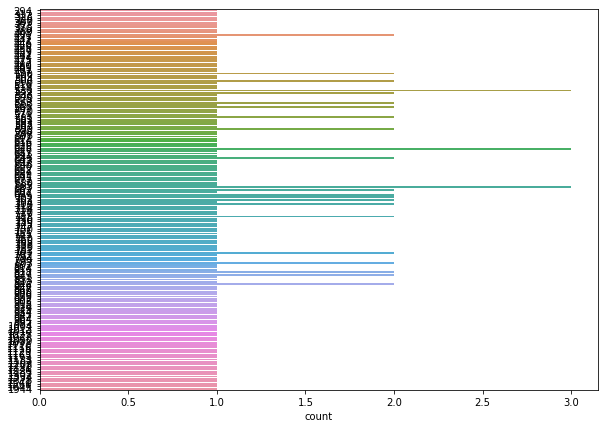

In [29]:
# Number of missing values in each column of data
missing_val_count_by_column = (new_data.isnull().sum())
missing_val_count_by_col = missing_val_count_by_column[missing_val_count_by_column > 0].sort_values(ascending=False)
print(f"Total {len(missing_val_count_by_col)} columns have missing value, and",
      f"Total {new_data.isnull().sum().sum()} missing values in dataset")
plt.figure(figsize=(10, 7))
sns.countplot(data=missing_val_count_by_col, y= missing_val_count_by_col )

In [36]:
new_imputer = SimpleImputer()
imputed_new_data = pd.DataFrame(new_imputer.fit_transform(new_data))
imputed_new_data.columns = new_data.columns
imputed_new_data.index = new_data.index

imputed_new_data.head()

cid,aab1-Primary solid Tumor,aab4-Primary solid Tumor,aab6-Primary solid Tumor,aab8-Primary solid Tumor,aab9-Primary solid Tumor,aaba-Primary solid Tumor,aabe-Primary solid Tumor,aabf-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,...,aauh-Primary solid Tumor,aaui-Primary solid Tumor,aaul-Primary solid Tumor,a8t3-Primary solid Tumor,a8t5-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,a8sy-Primary solid Tumor,a8lh-Primary solid Tumor,aapl-Primary solid Tumor
rid,,,,,,,,,,,,,,,,,,,,,
SLC35E2,7.45,8.1,7.200000,8.000000,7.65,8.100000,8.200000,8.2,7.55,8.450000,...,8.45,7.95,8.3,8.050000,8.2,7.25,7.4,7.350000,7.2,9.050000
A1BG,6.40,5.8,6.400000,5.800000,6.70,6.600000,6.300000,6.5,5.70,6.300000,...,7.10,7.10,6.7,7.000000,6.9,7.10,7.3,7.900000,6.0,6.900000
A1CF,4.70,5.7,3.000000,5.100000,4.40,4.200000,1.600000,6.8,6.00,7.431307,...,5.40,6.40,6.5,4.400000,3.3,3.60,6.2,1.200000,4.9,2.000000
A2BP1,-1.00,1.1,7.577068,7.728812,0.10,7.664173,7.628676,1.7,0.40,-1.500000,...,3.50,1.30,-0.3,7.685606,2.1,2.00,0.0,7.540936,2.0,7.660114
A2LD1,7.50,6.8,7.300000,7.500000,7.40,6.600000,7.100000,6.8,8.00,5.800000,...,6.50,7.30,6.1,6.700000,6.5,6.70,6.7,6.500000,6.9,6.700000


In [37]:
print(len(new_data.columns.unique()))
print(len(col_data.index.unique()))

183
183


In [38]:
col_to_merge = ['sample_type', 'mRNAseq_cluster','adenocarcinoma_invasion', 'vital_status', 'maximum_tumor_dimension', 'pathologic_stage', 'pathologic_m', 'pathologic_n', 'pathologic_t']
participant_id = col_data.participant_id
target_variable = col_data.sample_type
col_data = col_data.set_index('participant_id')
imputed_new_data = imputed_new_data.rename(columns=participant_id).T
imputed_new_data.head()

rid,SLC35E2,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
cid,,,,,,,,,,,,,,,,,,,,,
aab1,7.45,6.4,4.7,-1.000000,7.5,6.400000,14.3,10.6,8.8,1.000000,...,8.6,6.2,9.0,9.9,7.600244,9.2,12.9,10.1,9.3,5.5
aab4,8.10,5.8,5.7,1.100000,6.8,7.639954,14.0,10.2,5.6,-1.200000,...,8.8,5.8,8.5,10.0,7.639954,9.3,12.4,9.8,8.9,4.5
aab6,7.20,6.4,3.0,7.577068,7.3,10.800000,13.1,10.1,0.2,0.200000,...,9.1,3.9,8.1,10.0,-0.800000,9.4,13.5,9.8,9.2,4.7
aab8,8.00,5.8,5.1,7.728812,7.5,4.100000,13.8,8.6,3.2,-0.100000,...,8.9,5.2,8.5,9.7,1.900000,9.4,12.5,9.7,9.3,6.4
aab9,7.65,6.7,4.4,0.100000,7.4,9.300000,14.6,10.1,5.7,7.796027,...,8.4,5.9,8.6,9.9,0.100000,9.3,13.0,10.1,9.2,4.9


In [39]:
for col in col_to_merge:
    imputed_new_data[col] = col_data[col]
imputed_new_data.head(2)

rid,SLC35E2,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,...,psiTPTE22,sample_type,mRNAseq_cluster,adenocarcinoma_invasion,vital_status,maximum_tumor_dimension,pathologic_stage,pathologic_m,pathologic_n,pathologic_t
cid,,,,,,,,,,,,,,,,,,,,,
aab1,7.45,6.4,4.7,-1.0,7.5,6.400000,14.3,10.6,8.8,1.0,...,5.5,Primary solid Tumor,1.0,yes,dead,4.5,stage iib,m0,n1,t3
aab4,8.10,5.8,5.7,1.1,6.8,7.639954,14.0,10.2,5.6,-1.2,...,4.5,Primary solid Tumor,2.0,yes,alive,6.8,stage iib,m0,n1,t2


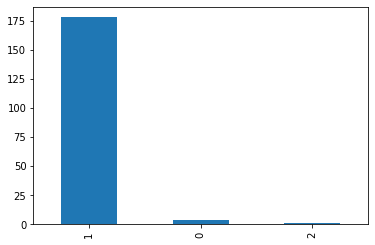

In [40]:
def cat_to_numeric(x):
    if x=='Solid Tissue Normal':
        return 0
    elif x=='Primary solid Tumor':
        return 1
    else:
        return 2
target_variable = target_variable.map(lambda x: cat_to_numeric(x))
target_variable.value_counts().plot(kind='bar')

In [41]:
def remove_nulls(df):

    rows = df.shape[0]
    columns = df.shape[1]
    null_cols = 0
    list_of_nulls_cols = []
    for col in list(df.columns):
        null_values_rows = df[col].isnull().sum()
        null_rows_pcn = round(((null_values_rows)/rows)*100, 2)
        col_type = df[col].dtype
        if null_values_rows > 0:
            print("The column {} has {} null values. It is {}% of total rows.".format(col, null_values_rows, null_rows_pcn))
            print("The column {} is of type {}.\n".format(col, col_type))
            null_cols += 1
            list_of_nulls_cols.append(col)
            df[[col]] = df[[col]].apply(lambda x: x.fillna(method='backfill'))
            print(f"The column {col} has removed {null_values_rows} null values")
    null_cols_pcn = round((null_cols/columns)*100, 2)
    print("The DataFrame has {} columns with null values. It is {}% of total columns.".format(null_cols, null_cols_pcn))
    return df

new_data = remove_nulls(imputed_new_data.select_dtypes(exclude='object'))

The column mRNAseq_cluster has 5 null values. It is 2.73% of total rows.
The column mRNAseq_cluster is of type float64.

The column mRNAseq_cluster has removed 5 null values
The column maximum_tumor_dimension has 14 null values. It is 7.65% of total rows.
The column maximum_tumor_dimension is of type float64.

The column maximum_tumor_dimension has removed 14 null values
The DataFrame has 2 columns with null values. It is 0.01% of total columns.


/home/omraj/.local/lib/python3.6/site-packages/pandas/core/frame.py:2960: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [42]:
imputed_new_data.isnull().sum().sum()

23

In [43]:
X_std = StandardScaler().fit_transform(imputed_new_data.drop(columns=col_to_merge))

n_components = 100
sklearn_pca = sklearnPCA(n_components=n_components)
Y_sklearn = sklearn_pca.fit_transform(X_std)

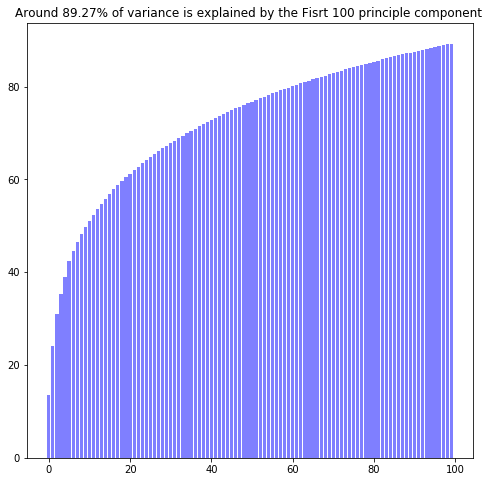

In [44]:
cum_sum = sklearn_pca.explained_variance_ratio_.cumsum()

explained_var = round(sklearn_pca.explained_variance_ratio_.sum()*100, 2)

cum_sum = cum_sum*100

fig, ax = plt.subplots(figsize=(8,8))
plt.bar(range(n_components), cum_sum, label='Cumulative _Sum_of_Explained _Varaince', color = 'b',alpha=0.5)
plt.title(f"Around {explained_var}% of variance is explained by the Fisrt {n_components} principle component ");

[]

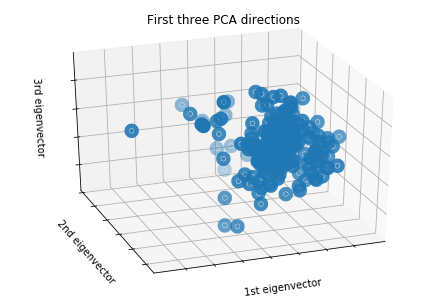

In [45]:
sklearn_pca = sklearnPCA(n_components=3)
X_reduced  = sklearn_pca.fit_transform(X_std)
Y=target_variable
plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],cmap=plt.cm.Paired,linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, 'This The 2D Transformation of above graph ')

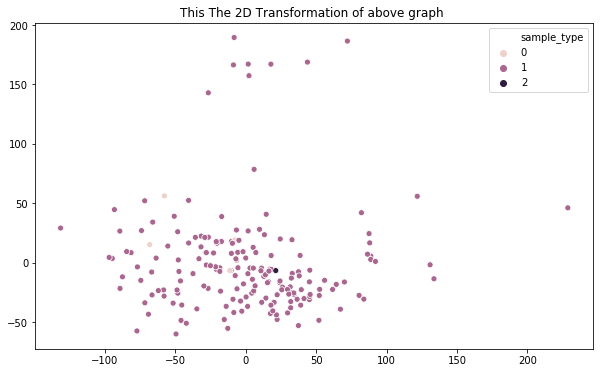

In [46]:
fig = plt.figure(1, figsize=(10,6))
sns.scatterplot(X_reduced[:, 0],  X_reduced[:, 1],hue=Y)
plt.title("This The 2D Transformation of above graph ")

# 2

In [47]:
imputed_new_data = imputed_new_data[imputed_new_data['adenocarcinoma_invasion']=='yes']
imputed_new_data.shape

(182, 18474)

In [48]:
ifn_sig = pd.read_csv('type1_IFN.txt', header=None)
ifn_sig.columns = ['member']
ifn_sig.head()

,member
0,IFIT1
1,IFI44
2,IFIT3
3,MX2
4,OAS1


In [49]:
ifn_sig_data = imputed_new_data[ifn_sig['member'].to_list()]
ifn_sig_data.shape

(182, 25)

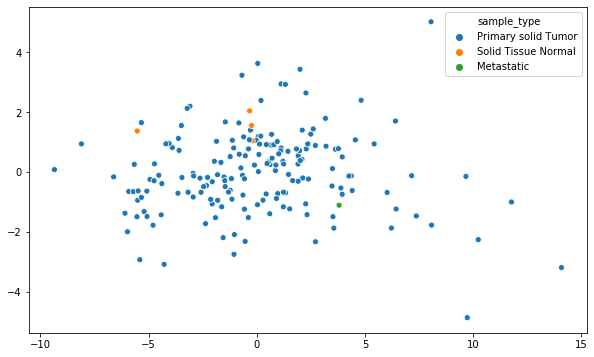

In [50]:
X_std = StandardScaler().fit_transform(ifn_sig_data)
n_components = 2
sklearn_pca = sklearnPCA(n_components=n_components)
X_reduced  = sklearn_pca.fit_transform(X_std)
fig = plt.figure(1, figsize=(10,6))
sns.scatterplot(X_reduced[:, 0],  X_reduced[:, 1],hue=imputed_new_data['sample_type'])


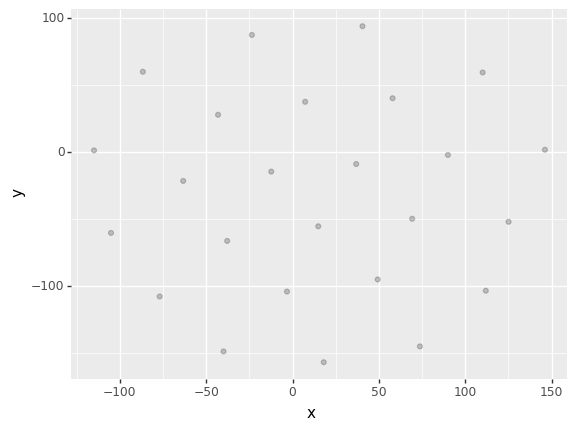

<ggplot: (8727826193840)>

In [51]:
XV = TSNE(n_components=2).\
    fit_transform(ifn_sig_data.T)
df = pd.DataFrame(XV).rename(columns={0:'x',1:'y'})
(ggplot(df,aes(x='x',y='y'))
 + geom_point(alpha=0.2)
)